<a href="https://colab.research.google.com/github/Jjmorenog/SimulacionUllanos2023/blob/main/Reto_ModeloSEIRV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ejercicio práctico: Modelo SEIRV para Colombia ###

__Realizado por:__  Boris Anghelo Rodríguez Rey y Nicole Rivera Parra

_Instituto de Física, Universidad de Antioquia_

En el presente Notebook podrá encontrar el ejercicio práctico propuesto para el taller "Modelación matemática de la epidemia de COVID-19" realizado el Lunes 10 de Agosto de 2020. Este tiene como finalidad reafirmar los conceptos y herramientas compartidas durante el encuentro.

In [ ]:
###=== Importar librerías a usar ===###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


__Descripción modelo SEIRV__

Como se ha expuesto en la reunión, los modelos $SEIRV$ tienen 5 variables de estado las cuales dan cuenta de:

- Población suceptible ($S$)
- Población expuesta al virus ($E$) (_portadores asintomaticos o sanos que propagan el virus_)
- Población infectada ($I$)
- Población recuperada ($R$)
- Concentración de virus en el ambiente ($V$)

y, de acuerdo a los estudios realizados a raíz de la pandemia del COVID-19, se adapta el [modelo epidemiológico SEIRV en Wuhan, China](http://www.aimspress.com/article/10.3934/mbe.2020148) al caso colombiano, el cual viene dado por las siguientes ecuaciones diferenciales para la evolución temporal e interacción de los mismos:

---

$$ \frac{dS}{dt} = \Lambda - \beta_1(E) E S - \beta_2(I) S I - \beta_3(V) S V - \mu S $$

---

$$ \frac{dE}{dt} =  \beta_1(E) E S + \beta_2(I) S I + \beta_3(V) S V - (\alpha + \mu) E $$

---

$$ \frac{dI}{dt} = \alpha E - (\omega + \gamma + \mu) I $$

---

$$ \frac{dR}{dt} = \gamma I - \mu R $$

---

$$ \frac{dV}{dt} = \xi_1 E + \xi_2 I - \sigma V $$

---

Donde encontramos los siguiente parámetros:

$\Lambda \ (\frac{personas}{dia}) = 15.098 \times 5 \times 10^4 \times \frac{1}{365} $: Tasa de natalidad. se usa dato reportado por el banco mundial en el 2017.

$\mu \ (\frac{1}{dia}) = \frac{5.503 \times 5 \times 10^4}{5 \times 10^6 \times 365} $: Tasa de muertes naturales. Se usa dato reportado por el BM de 5.503 por mil habitantes.

$\alpha \ (\frac{1}{dia})=\frac{1}{7}$: Frecuencia de incubación.

$\omega \ (\frac{1}{dia})= 10^{-2} $: Tasa de muerte inducida por el virus.

$\gamma \ (\frac{1}{dia})= \frac{1}{15} $: Tasa de recuperación.

$\xi_1 \ (\frac{1}{dia}) = 2.30$: Tasa de dispersión del virus al ambiente por los individuos sanos portadores.

$\xi_2 \ (\frac{1}{dia}) = 0$: Tasa de dispersión del virus al ambiente por los individuos enfermos.

$\sigma \ (\frac{1}{dia}) = 1$: Tasa de remoción del virus en el ambiente.

Y, las __Funciones de Contacto Directo__ (tasas $\beta$) toman la forma $$ \beta_i(x) = \frac{\beta_0(i)}{1 + c(i)x}  $$ siendo $\beta_1$ para el contacto E-S (transmisión directa expuestos-sanos), $\beta_2$ para el contacto (transmisión directa infectados-sanos) I-S y  $\beta_3$ para el contacto S-V (transmisión indirecta sanos-ambiente). Ademas, se tienen los siguientes valores para la constante de transmisión $\beta_0$ ($\frac{1}{persona \ dia}$) y  el coeficiente de ajuste para la transmisión $c$ ($\frac{1}{persona}$).

$$ \beta_0 = [1.65 \times 3.11 \times 10^{-9}, 1.6 \times 0.62 \times 10^{-9}, 1.6 \times 1.03 \times 10^{-9}] $$

$$ c = [1.01 \times 10^{-4}, \ 1.01 \times 10^{-4}, \ 1.01 \times 10^{-4}  ] $$

cabe notar que los anteriores valores han sido adaptados a partir de los datos disponibles para Colombia.

$ \\ $

__Actividad propuesta__

A partir de la descripción del modelo SEIRV y sus datos para colombia, completar las celdas de código señaladas con el fin de visualizar el ajuste del modelo con los datos de Colombia en los primeros 20 días de la pandemia.

In [ ]:
###=== Definir parámetros fijos ===###
#- Escribir los valores correspondientes -#

lbd =  (15.098*5*pow(10,4))/365       #Tasa de natalidad
mu =   (5.503*5*pow(10,4))/(5*pow(10, 6)*365)       #Tasa de muertes naturales
alpha =  1/7     #Frecuencia de incubación
omega =  pow(10, -2)     #Tasa de muerte inducida por el virus
gama =   (1/15)     #Tasa de recuperación
xi_1 =   2.30     #Tasa de dispersión del virus al ambiente por los individuos sanos portadores
xi_2 =   0     #Tasa de dispersión del virus al ambiente por los individuos enfermos
sigma =  1     #Tasa de remoción del virus en el ambiente

In [ ]:
###=== Definimos la función beta ===###
def beta_fun(i, x):
    b0 = [1.65*3.11*pow(10, -9), 1.6*0.62*pow(10, -9), 1.6*1.03*pow(10, -9)]
    c = [1.01*pow(10, -4), 1.01*pow(10, -4), 1.01*pow(10, -4)]

    b = b0[i-1] / (1 + c[i-1]*x)

    return b

In [ ]:
##=== Definiendo sistema de ecuaciones ===##
#- Completar los terminos faltantes -#

def syst(y, t, beta, xi_2):
    S, E, I, R, V = y

    dS = lbd - beta(1, E)*E*S - beta(2, I)*S*I - beta(3,V)*S*V - mu*S
    dE = beta(1,E)*E*S + beta(2,I)*S*I + beta(3,V)*S*V - (alpha + mu)*E
    dI = (alpha*E)-((omega+gama+mu)*I)
    dR = (gama*I)-(mu*R)
    dV = (xi_1*E)-(xi_2*I)-(sigma*V)

    return [dS, dE, dI, dR, dV]

Para definir las condiciones iniciales, le sugerimos considere que la población colombiana es de 50 millones de habitantes aproximadamente, no hay expuestos, infectados o recuperados en el tiempo inicial. Además, se asume una concentración inicial del virus en el ambiente de 100.

In [ ]:
###=== Definir las condiciones iniciales ===###
#- Completar los espacios vacíos en la lista -#
cond_col = [ 50000000,0  ,0  ,0  ,100  ]

Para el tiempo de integración considere que, queremos visualizar la evolución de nuestro sistema durante 300 días.

In [ ]:
###=== Definir tiempo de integración ===###
#- Escriba el tiempo final -#
time_col = np.arange(0,300 )

Para integrar el sistema se usará nuevamente la función odeint

In [ ]:
##=== Integrando sistema de ecuaciones para colombia ===###
Col_sol = integrate.odeint(syst, cond_col, time_col, args=(beta_fun, xi_2) )

Las gráficas han sido ya definidas en las siguientes líneas de código. Si realizó correctamente el ejercicio, ellas ilustrarán el resultado esperado.

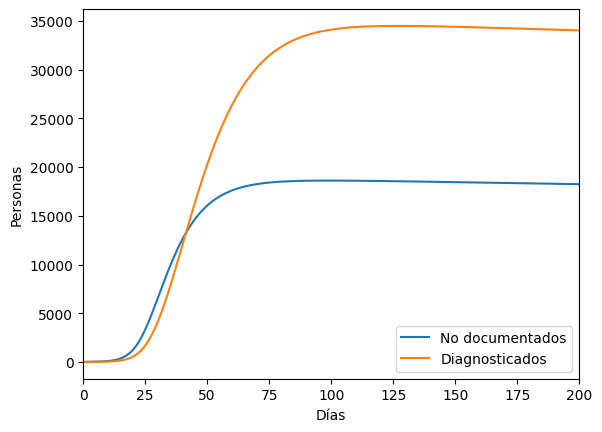

In [ ]:
##=== Graficando primeros resultados ===###
plt.plot(time_col, Col_sol[:, 1], label="No documentados")
plt.plot(time_col, Col_sol[:, 2], label="Diagnosticados")
plt.xlabel("Días")
plt.ylabel("Personas")
plt.xlim(0, 200)
plt.legend()
plt.show()

In [ ]:
###=== Casos confirmados del INS ===###
INS_data = [1, 1, 1, 3, 3, 9, 14, 19, 37, 53, 67, 92, 104, 130, 178, 212, 241, 314]

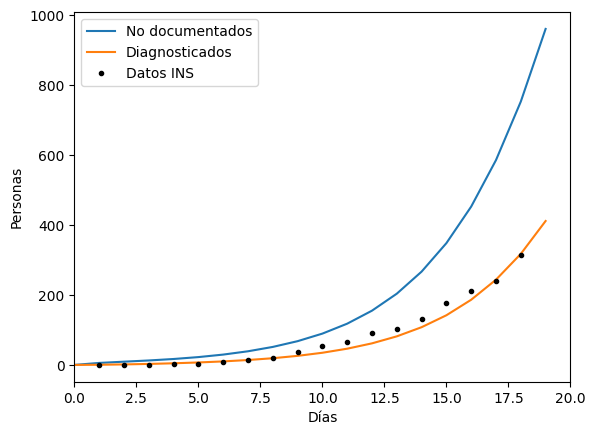

In [ ]:
##=== Graficando modelo para primeros 20 días ===###
plt.plot(time_col[0:20], Col_sol[0:20, 1], label="No documentados")
plt.plot(time_col[0:20], Col_sol[0:20, 2], label="Diagnosticados")
plt.plot(time_col[1:19], INS_data, 'k.', label="Datos INS")
plt.xlabel("Días")
plt.ylabel("Personas")
plt.xlim(0, 20)
plt.legend()
plt.show()